# Feature Engineering


## 1. Import packages

In [176]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

---
## 2. Load data

In [108]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [109]:
df.head(3)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,mean_3m_price_off_peak_var,mean_3m_price_peak_var,mean_3m_price_mid_peak_var,mean_3m_price_off_peak_fix,mean_3m_price_peak_fix,mean_3m_price_mid_peak_fix,mean_3m_price_off_peak,mean_3m_price_peak,mean_3m_price_mid_peak,churn
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [110]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [111]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [112]:
df=pd.merge(df,diff, on='id' )

average price differences across different time periods

In [113]:
mean_prices = price_df.groupby(['id']).agg({'price_off_peak_var': 'mean','price_peak_var': 'mean',
                                            'price_mid_peak_var': 'mean','price_off_peak_fix': 'mean',
                                            'price_peak_fix': 'mean','price_mid_peak_fix': 'mean'}).reset_index()

mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']

mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [116]:
cols=['id','off_peak_peak_var_mean_diff', 'peak_mid_peak_var_mean_diff',
       'off_peak_mid_peak_var_mean_diff', 'off_peak_peak_fix_mean_diff',
       'peak_mid_peak_fix_mean_diff', 'off_peak_mid_peak_fix_mean_diff']
df=pd.merge(df, mean_prices[cols] , on = 'id')

In [118]:
df.head(3)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,mean_3m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,8.182687,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.45067,26.040925
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.000000,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.00000,44.311375
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.000000,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.00000,44.385450


Maximum price difference between months

In [119]:
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean','price_peak_var': 'mean',
                                                                   'price_mid_peak_var': 'mean','price_off_peak_fix': 'mean',
                                                                   'price_peak_fix': 'mean','price_mid_peak_fix': 'mean'}).reset_index()


mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']

mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']


In [121]:
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({'off_peak_peak_var_mean_diff': 'max',
                                                                           'peak_mid_peak_var_mean_diff': 'max',
                                                                           'off_peak_mid_peak_var_mean_diff': 'max',
                                                                           'off_peak_peak_fix_mean_diff': 'max',
                                                                           'peak_mid_peak_fix_mean_diff': 'max',
                                                                           'off_peak_mid_peak_fix_mean_diff': 'max'
                                                                          }).reset_index().rename(columns={
    'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_mean_diff':'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_mean_diff':'off_peak_mid_peak_fix_max_monthly_diff'})

In [124]:
df=pd.merge(df, max_diff_across_periods_months, on='id')
df.head(3)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.058257,18.590255,7.45067,26.040925,0.060550,0.085483,0.146033,44.26693,8.145775,44.26693
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.149609,44.311375,0.00000,44.311375,0.151367,0.085483,0.151367,44.44471,0.000000,44.44471
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.170512,44.385450,0.00000,44.385450,0.084587,0.089162,0.172468,44.44471,0.000000,44.44471


convert dates to months

In [130]:
def convert_months(reference_date, df, column):###     Input a column with timedeltas and return months
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months

reference_date = datetime.datetime(2016, 1, 1)


df['months_activ'] = convert_months(reference_date, df, 'date_activ') 
#customers who have been around longer are likely to stick around

df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
#whether customers are nearing the end of the contract or not

df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
# how long since the contract has been modified

df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')
#how long since the contract has been renewed

drop_cols = ['date_activ','date_end','date_modif_prod','date_renewal']
df = df.drop(columns=drop_cols)
df.head(3)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,...,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,months_activ,months_to_end,months_modif_prod,months_renewal
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,...,0.060550,0.085483,0.146033,44.26693,8.145775,44.26693,30,5,2,6
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,...,0.151367,0.085483,0.151367,44.44471,0.000000,44.44471,76,7,76,4
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,...,0.084587,0.089162,0.172468,44.44471,0.000000,44.44471,68,3,68,8


Categorical data

In [136]:
encode_col=['channel_sales','origin_up','has_gas']
for col in encode_col:
    le=LabelEncoder()
    df[col]=le.fit_transform(df[col])

In [140]:
df.head(3)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,...,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,months_activ,months_to_end,months_modif_prod,months_renewal
0,0,24011ae4ebbe3035111d65fa7c15bc57,4,0,54946,0,0.00,0,0.0,1.78,...,0.060550,0.085483,0.146033,44.26693,8.145775,44.26693,30,5,2,6
1,1,d29c2c54acc38ff3c0614d0a653813dd,0,4660,0,0,189.95,0,0.0,16.27,...,0.151367,0.085483,0.151367,44.44471,0.000000,44.44471,76,7,76,4
2,2,764c75f661154dac3a6c254cd082ea7d,4,544,0,0,47.96,0,0.0,38.72,...,0.084587,0.089162,0.172468,44.44471,0.000000,44.44471,68,3,68,8


Transforming numerical data

apply a log transform to deal with skewed data

In [143]:
skewed_cols = ['cons_12m','cons_gas_12m','cons_last_month','forecast_cons_12m','forecast_cons_year',
               'forecast_discount_energy','forecast_meter_rent_12m','forecast_price_energy_off_peak',
               'forecast_price_energy_peak','forecast_price_pow_off_peak']
df[skewed_cols].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460500e+04,1.460500e+04,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000
mean,1.592303e+05,2.809108e+04,16091.371448,1868.638618,1399.858747,0.966450,63.090448,0.137282,0.050488,43.130085
std,5.734836e+05,1.629786e+05,64366.262314,2387.651549,3247.876793,5.108355,66.166636,0.024623,0.049037,4.486140
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674000e+03,0.000000e+00,0.000000,494.980000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411600e+04,0.000000e+00,793.000000,1112.610000,314.000000,0.000000,18.800000,0.143166,0.084138,44.311378
75%,4.076400e+04,0.000000e+00,3383.000000,2402.270000,1746.000000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


In [144]:
for col in skewed_cols:
    df[col]=np.log10(df[col]+1)

In [145]:
df[skewed_cols].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000
mean,4.223945,0.778978,2.264801,2.962162,1.784733,0.050868,1.517233,0.055766,0.020917,1.636057
std,0.884545,1.716828,1.769266,0.683612,1.584972,0.267329,0.571489,0.009438,0.020297,0.134242
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.753966,0.000000,0.000000,2.695464,0.000000,0.000000,1.235023,0.047796,0.000000,1.619163
50%,4.149742,0.000000,2.899821,3.046733,2.498311,0.000000,1.296665,0.058109,0.035085,1.656207
75%,4.610287,0.000000,3.529430,3.380803,3.242293,0.000000,2.120673,0.059316,0.040933,1.656207
max,6.792889,6.618528,5.887169,4.918575,5.243970,1.491362,2.778376,0.105157,0.077722,1.780075


In [147]:
df.head(3)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,...,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,months_activ,months_to_end,months_modif_prod,months_renewal
0,0,24011ae4ebbe3035111d65fa7c15bc57,4,0.000000,4.739944,0.0,0.000000,0.0,0.0,0.444045,...,0.060550,0.085483,0.146033,44.26693,8.145775,44.26693,30,5,2,6
1,1,d29c2c54acc38ff3c0614d0a653813dd,0,3.668479,0.000000,0.0,2.280920,0.0,0.0,1.237292,...,0.151367,0.085483,0.151367,44.44471,0.000000,44.44471,76,7,76,4
2,2,764c75f661154dac3a6c254cd082ea7d,4,2.736397,0.000000,0.0,1.689841,0.0,0.0,1.599009,...,0.084587,0.089162,0.172468,44.44471,0.000000,44.44471,68,3,68,8


Dropping highly correlated features

<AxesSubplot:>

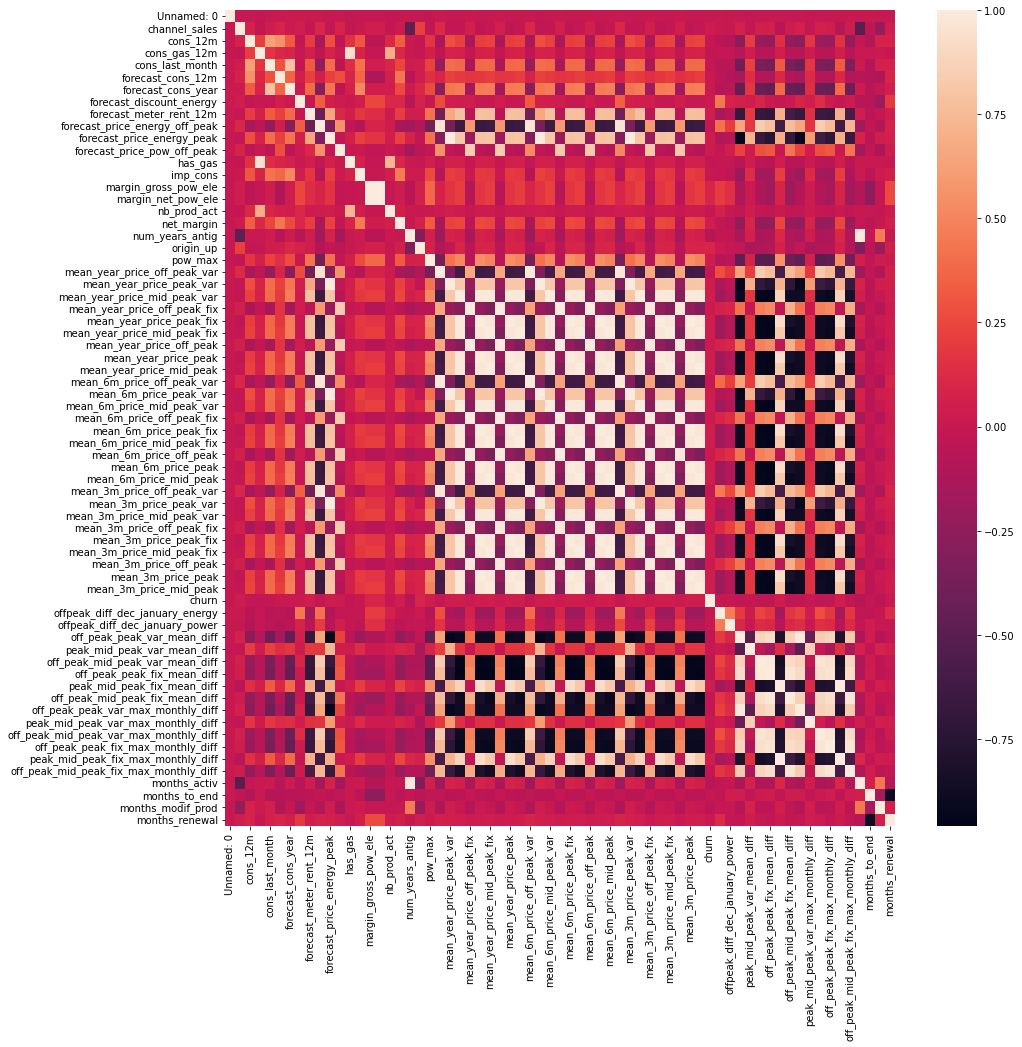

In [150]:
cor=df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(cor)

In [151]:
upper_tri = cor.where(np.triu(np.ones(cor.shape),k=1).astype(np.bool))

C:\Users\Apaala\AppData\Local\Temp\ipykernel_12128\2816014682.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor.where(np.triu(np.ones(cor.shape),k=1).astype(np.bool))


In [164]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > .99)]
print(to_drop)
print(len(to_drop))

['margin_net_pow_ele', 'mean_year_price_peak_var', 'mean_year_price_mid_peak_fix', 'mean_year_price_off_peak', 'mean_year_price_peak', 'mean_year_price_mid_peak', 'mean_6m_price_peak_var', 'mean_6m_price_mid_peak_var', 'mean_6m_price_off_peak_fix', 'mean_6m_price_peak_fix', 'mean_6m_price_mid_peak_fix', 'mean_6m_price_off_peak', 'mean_6m_price_peak', 'mean_6m_price_mid_peak', 'mean_3m_price_off_peak_var', 'mean_3m_price_peak_var', 'mean_3m_price_mid_peak_var', 'mean_3m_price_off_peak_fix', 'mean_3m_price_peak_fix', 'mean_3m_price_mid_peak_fix', 'mean_3m_price_off_peak', 'mean_3m_price_peak', 'mean_3m_price_mid_peak', 'off_peak_peak_var_max_monthly_diff', 'peak_mid_peak_fix_max_monthly_diff']
25


In [165]:
df=df.drop(columns=to_drop)

# Training the model

In [166]:
y=df['churn']
X=df.drop(columns=['churn', 'Unnamed: 0'])

In [167]:
X.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,months_activ,months_to_end,months_modif_prod,months_renewal
0,24011ae4ebbe3035111d65fa7c15bc57,4,0.000000,4.739944,0.000000,0.000000,0.000000,0.0,0.444045,0.047073,...,7.450670,26.040925,0.085483,0.146033,44.266930,44.26693,30,5,2,6
1,d29c2c54acc38ff3c0614d0a653813dd,0,3.668479,0.000000,0.000000,2.280920,0.000000,0.0,1.237292,0.059075,...,0.000000,44.311375,0.085483,0.151367,44.444710,44.44471,76,7,76,4
2,764c75f661154dac3a6c254cd082ea7d,4,2.736397,0.000000,0.000000,1.689841,0.000000,0.0,1.599009,0.066622,...,0.000000,44.385450,0.089162,0.172468,44.444710,44.44471,68,3,68,8
3,bba03439a292a1e166f80264c16191cb,5,3.200029,0.000000,0.000000,2.382089,0.000000,0.0,1.318689,0.059448,...,0.000000,44.400265,0.000000,0.153133,44.444710,44.44471,69,2,69,9
4,149d57cf92fc41cf94415803a877cb4b,0,3.646011,0.000000,2.721811,2.650065,2.721811,0.0,2.122969,0.048014,...,8.137629,24.412893,0.033743,0.055866,16.291555,24.43733,71,2,71,9


In [168]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['id']), y, test_size=0.25, random_state=42)

In [169]:
model=RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier()

In [170]:
y_pred=model.predict(X_test)

In [184]:
y_test.value_counts()

0    3279
1     373
Name: churn, dtype: int64

In [179]:
print(f"Accuracy: {accuracy_score(y_pred,y_test)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")

Accuracy: 0.9022453450164294
Precision: 0.9444444444444444
Recall: 0.045576407506702415


In [185]:
tn, fn, fp, tp = confusion_matrix(y_pred,y_test).ravel()
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

True positives: 17
False positives: 1
True negatives: 3278
False negatives: 356



We use these metrics to explain not only how accurately our model is classifying customers but also to figure out what our models shortcomings are

In this case
1. Out of 3279 customers that did not churn we are able to predict 3278 correctly(true positives)
2. false negatives: we predicted 356 customers to have not churned when they did in fact churn
3. false postives: we only predict 1 customer to have churned when they didn't
4. we predict 17 customers to have correctly churned

Our model has a poor recall score which means that the proportion of correctly idenfied positives(customers who churned) was low

## Feature importance

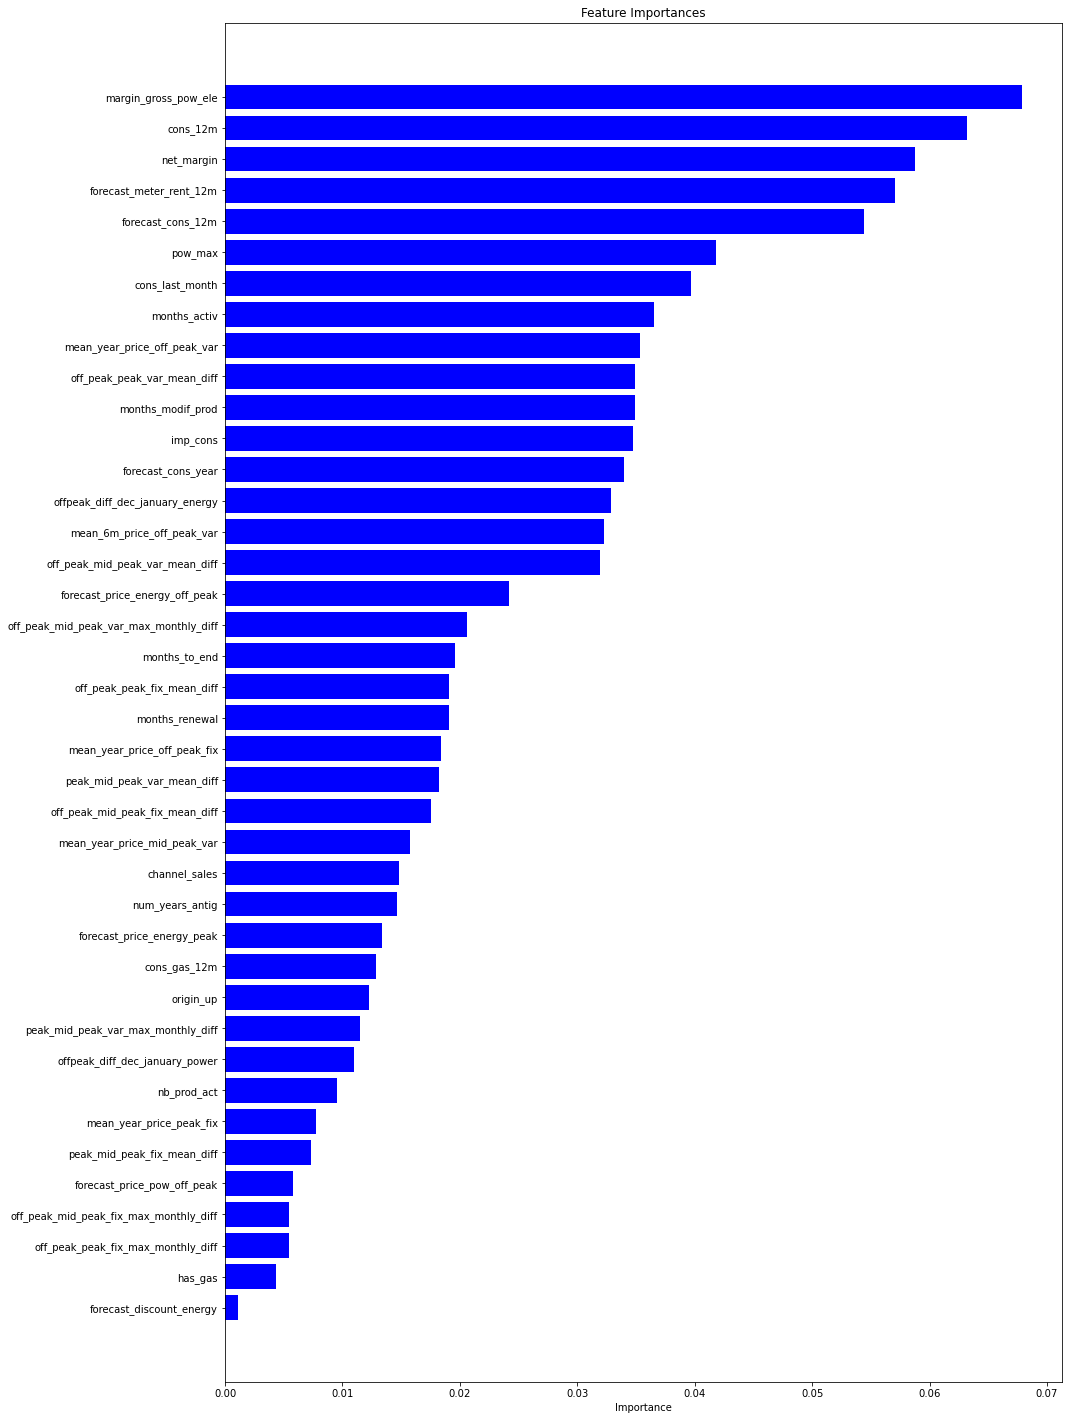

In [187]:
feature_importances = pd.DataFrame({'features': X_train.columns,'importance': model.feature_importances_}).sort_values(by='importance', ascending=True).reset_index()
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'],color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

In [189]:
proba_predictions = model.predict_proba(X_test)
probabilities = proba_predictions[:, 1]

X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

X_test['churn'] =y_pred.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('out_of_sample_data_with_predictions.csv')


# Impact of the discount

We try to predict the revenue when
1. no intervention
2. the proposed discount is offered

for 2. we assume everyone who is offered the discount will accept it

We will also use this to figure out the customers to whom the discount should be offered to maximize revenue

In [190]:
test_df=X_test
test_df.head(3)

,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,months_activ,months_to_end,months_modif_prod,months_renewal,churn,churn_probability
0,4,5.705621,0.000000,4.715176,0.000000,0.000000,0.0,2.166341,0.049362,0.042767,...,0.033742,0.055866,16.226395,24.339590,35,12,35,0,1,0.59
1,5,6.000648,5.203623,5.050759,2.818932,3.065206,0.0,1.312177,0.058768,0.000000,...,0.000000,0.151250,44.444710,44.444710,67,4,67,7,0,0.19
2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.125774,0.038403,0.035987,...,0.028134,0.040781,22.682779,50.805737,90,11,90,0,0,0.00


In [193]:
#Calculating baseline revenue
test_df['basecase_revenue'] = (np.power(10, test_df['forecast_cons_12m']) + 1)* test_df['forecast_price_energy_off_peak'] +test_df['forecast_meter_rent_12m']
test_df['basecase_revenue_after_churn'] = test_df['basecase_revenue'] * (1 - 0.919 * test_df['churn'])
test_df.head(3)

,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,off_peak_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,months_activ,months_to_end,months_modif_prod,months_renewal,churn,churn_probability,basecase_revenue,basecase_revenue_after_churn
0,4,5.705621,0.000000,4.715176,0.000000,0.000000,0.0,2.166341,0.049362,0.042767,...,16.226395,24.339590,35,12,35,0,1,0.59,2.265066,0.183470
1,5,6.000648,5.203623,5.050759,2.818932,3.065206,0.0,1.312177,0.058768,0.000000,...,44.444710,44.444710,67,4,67,7,0,0.19,40.103378,40.103378
2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.125774,0.038403,0.035987,...,22.682779,50.805737,90,11,90,0,0,0.00,2.202579,2.202579


We fix the cutoff probability to be 0.5. That is, for customers with churn probability more than 50% we offer the discount and for those below 50% no discount is offered

Further we assume that customers who are offered a discount do not churn within the next year and so their revenue is 0.8 times the basecase revenue

We also assume that customers who are not offered a discount do churn



In [196]:
def get_rev_delta(pred: pd.DataFrame, cutoff: float=0.5, discount: float=0.2)-> float:
    """
    Get the delta of revenues for offering discount for all customers with␣
    ,→predicted churn risk >= cutoff
    """
    pred['discount_revenue'] = pred['basecase_revenue_after_churn']
# Churn predicted => discount is given => customer stays for full year,independent of whether the prediction
# (false positive, "free"/unnecessary discount given) or correct
    pred.loc[pred['churn_probability'] >= cutoff, 'discount_revenue'] =pred['basecase_revenue'] * (1 - discount)
# Save the revenue delta for each customer in a separate column
    pred['revenue_delta'] = pred['discount_revenue'] -pred['basecase_revenue_after_churn']
    return pred['revenue_delta'].sum()


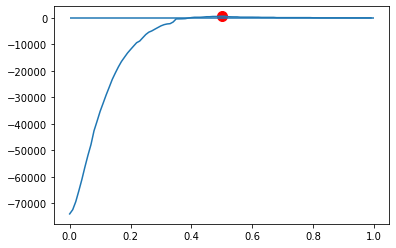

Maximum benefit at cutoff 0.5 with revenue delta of $640.16


In [197]:
rev_deltas = pd.Series({cutoff: get_rev_delta(test_df, cutoff=cutoff) for cutoff in np.arange(0, 1, 0.01)})
def plot_tradeoff(rev_deltas: pd.Series):
# Plot the revenue deltas
    rev_deltas.plot()
# Mark optimal point
    max_pred = rev_deltas.idxmax()
    plt.scatter(max_pred, rev_deltas.loc[max_pred], s=100, c='red')
# Reference line for break-even
    plt.hlines(0, 0, 1)
    plt.show()
    print(f'Maximum benefit at cutoff {max_pred} with revenue delta of ${rev_deltas.loc[max_pred]:,.2f}')
    
plot_tradeoff(rev_deltas)
